In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Rescaling
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, LayerNormalization
import tensorflow_addons as tfa
import pickle

2022-06-16 08:24:17.066171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-16 08:24:17.066212: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_path = "./train"
test_path = "./test"

In [3]:
def process_data(img_dims, batch_size):
  train_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_gen = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
  )

  test_gen = test_datagen.flow_from_directory(
      directory=test_path,
      target_size=(img_dims, img_dims),
      batch_size=batch_size,
      class_mode='binary',
      shuffle=True
  )

  return (train_gen, test_gen)

In [4]:
img_dims = 160
epochs=100
batch_size=16

train_gen, test_gen = process_data(img_dims, batch_size)

Found 12134 images belonging to 2 classes.
Found 2615 images belonging to 2 classes.


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [6]:
num_classes = 2
input_shape = (160, 160, 3)

In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 100
image_size = 160  # We'll resize input images to this size
patch_size = 40  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2 # number of patches will be 16 or (160*160)/(40*40)

# hyperparameters for the vision transformer model itself
projection_dim = 64 # size of the hidden dimension feature vectors, the patches are projected into these 64 dimesional feature vectors, which are then concatenated as input into the first transformer encoder layer
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [9]:
class Patches(layers.Layer):
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size,
        })
        return config

    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [10]:
class PatchEncoder(layers.Layer):
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding,
        })
        return config

    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [23]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [26]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'FalseNegatives', 'FalsePositives', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives'],
    )
        # metrics=['accuracy', 'FalseNegatives', 'FalsePositives', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives']


    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_gen,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=test_gen,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, FalseNegatives, FalsePositives, Precision, Recall, TrueNegatives, TruePositives = model.evaluate(test_gen)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test FalseNegatives: {FalseNegatives}%")
    print(f"Test FalsePositives: {FalsePositives}%")
    print(f"Test Precision: {Precision}%")
    print(f"Test Recall: {Recall}%")
    print(f"Test TrueNegatives: {TrueNegatives}%")
    print(f"Test TruePositives: {TruePositives}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
759/759 [==============================] - 68s 80ms/step - loss: 0.6485 - accuracy: 0.6845 - false_negatives: 2231.0000 - false_positives: 1597.0000 - precision: 0.6687 - recall: 0.5909 - true_negatives: 5083.0000 - true_positives: 3223.0000 - val_loss: 0.5609 - val_accuracy: 0.7361 - val_false_negatives: 673.0000 - val_false_positives: 17.0000 - val_precision: 0.9475 - val_recall: 0.3133 - val_true_negatives: 1618.0000 - val_true_positives: 307.0000
Epoch 2/100
759/759 [==============================] - 60s 78ms/step - loss: 0.4638 - accuracy: 0.7865 - false_negatives: 1864.0000 - false_positives: 727.0000 - precision: 0.8316 - recall: 0.6582 - true_negatives: 5953.0000 - true_positives: 3590.0000 - val_loss: 0.4553 - val_accuracy: 0.7973 - val_false_negatives: 461.0000 - val_false_positives: 69.0000 - val_precision: 0.8827 - val_recall: 0.5296 - val_true_negatives: 1566.0000 - val_true_positives: 519.0000
Epoch 3/100
759/759 [==============================] - 59s 78ms/ste

In [27]:
vit_classifier.save("vit.h5")

/home/dhiraj/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [28]:
with open('vit_hist.pkl', 'wb') as f:
  pickle.dump(history.history, f)

In [1]:
import pickle
file = open("vit_hist.pkl",'rb')
hist = pickle.load(file)
file.close()

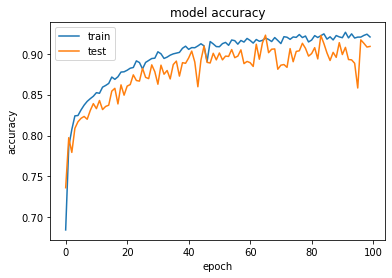

In [2]:
import matplotlib.pyplot as plt

plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

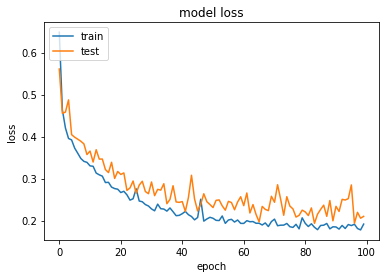

In [3]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.legend(['train', 'test'], loc='upper left')
plt.show()